In [3]:
# So local imports work
import os
path_sections = os.getcwd().split('\\')
if path_sections[-1] != 'CGM':
    os.chdir('./..')

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from data_processing.cgm_data import CGMData
from data_processing.derived_datasets import max_glucose_dataset, align_series, max_glucose_between_meals_dataset

In [5]:
cgm_data = CGMData()

In [6]:
slices = []
for i in range(1, 11):
    df = max_glucose_dataset(cgm_data, i)
    slices.append(df)
food_consumption = pd.concat(slices)

In [7]:
# food_consumption = food_consumption[~food_consumption['max_glucose'].isnull()]
food_consumption.head()

,calorie,total_carb,dietary_fiber,sugar,protein,total_fat,gi,gl,recent_meals,participant,max_glucose,start_glucose,diff_glucose,mean_temp,mean_hr,mean_acc,mean_eda,high_glucose
0,456.0,85.0,1.7,83.0,16.0,3.3,33.0,28.050,1.0,1,143.0,59.0,84.0,33.605343,76.982429,0.924898,0.478566,False
1,488.0,2.5,1.2,0.8,63.4,23.1,28.0,0.700,1.0,1,106.0,104.0,2.0,34.328719,68.960515,0.661794,2.321904,False
2,230.0,35.0,0.0,18.0,13.0,0.0,56.5,24.620,1.0,1,122.0,92.0,30.0,33.882256,77.987660,0.791241,0.568190,False
3,280.0,30.0,0.0,22.0,4.0,0.0,62.0,18.600,1.0,1,110.0,89.0,21.0,31.511428,87.463506,0.964078,0.483317,False
4,358.0,14.4,0.0,8.7,13.9,0.0,28.0,4.032,1.0,1,124.0,105.0,19.0,30.470737,75.821212,0.461761,0.209723,False


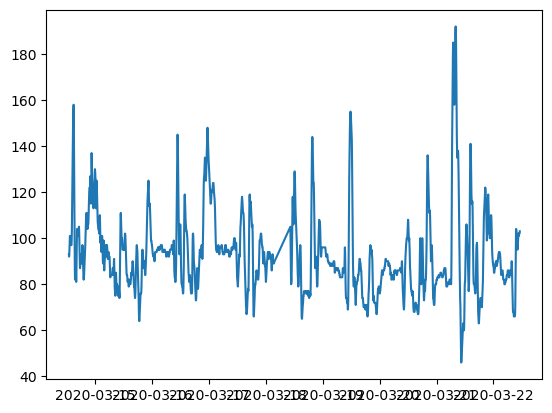

In [8]:
plt.plot(cgm_data[7].glu)

In [9]:
food_consumption.describe()

,calorie,total_carb,dietary_fiber,sugar,protein,total_fat,gi,gl,recent_meals,participant,max_glucose,start_glucose,diff_glucose,mean_temp,mean_hr,mean_acc,mean_eda
count,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.0,219.00000,195.000000,195.000000,195.000000,165.000000,166.000000,165.000000,165.000000
mean,438.854795,51.159817,3.299087,20.805479,20.487215,13.580365,52.332763,33.121183,1.0,5.30137,140.753846,105.856410,34.897436,33.095259,82.963613,0.955629,1.046168
std,375.876463,44.622824,4.078125,22.330501,21.832963,24.105040,19.442353,32.484044,0.0,2.64064,30.424165,17.883065,27.426749,1.530461,8.234034,0.505163,1.642839
min,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,28.000000,0.000000,1.0,1.00000,83.000000,59.000000,0.000000,27.994476,60.828234,0.076339,0.043810
25%,210.550000,18.500000,0.000000,4.050000,6.550000,0.000000,34.525000,8.506000,1.0,3.00000,118.000000,94.000000,14.000000,32.318955,77.788762,0.589569,0.200812
50%,314.000000,40.000000,1.600000,15.000000,12.800000,6.000000,53.000000,24.732000,1.0,5.00000,139.000000,104.000000,33.000000,33.406887,82.721748,0.958318,0.432557
75%,582.000000,70.000000,5.200000,26.650000,29.450000,21.700000,62.000000,45.460000,1.0,7.50000,155.000000,114.500000,48.500000,34.186849,87.056936,1.322171,1.114973
max,2473.900000,248.000000,19.300000,96.700000,127.000000,290.500000,85.000000,188.240000,1.0,10.00000,261.000000,165.000000,172.000000,36.178093,116.000256,2.202002,10.452984


In [10]:
food_consumption = food_consumption[~food_consumption['max_glucose'].isnull()]
food_train, food_test = train_test_split(food_consumption, train_size=0.2, random_state=5, shuffle=True)

In [11]:
def lr_cv_loop(data, model, features, target):
    n_splits = 5
    kfold = KFold(n_splits=n_splits)

    mses = np.zeros(n_splits)

    for i, (train_idx, val_idx) in enumerate(kfold.split(data)):
        d_tr = data.iloc[train_idx]
        d_val = data.iloc[val_idx]
        model.fit(d_tr[features], d_tr[target])
        pred = model.predict(d_val[features])

        mses[i] = mean_squared_error(d_val[target], pred)

    return mses


In [12]:
features = ['total_carb']
target = 'max_glucose'
exog = LinearRegression()
mses = lr_cv_loop(food_train, exog, features, target)
np.sqrt(mses).mean()

26.03993134900302

In [13]:
features = ['calorie', 'total_carb', 'sugar', 'protein']
target = 'max_glucose'
exog = LinearRegression()
mses = lr_cv_loop(food_train, exog, features, target)
np.sqrt(mses).mean()

27.28571922893554

In [14]:
cgm_data[1].food

,time_end,logged_food,amount,unit,searched_food,calorie,total_carb,dietary_fiber,sugar,protein,total_fat,gi,gl
time_begin,,,,,,,,,,,,,
2020-02-13 18:00:00,NaT,Berry Smoothie,20.00,fluid ounce,Strawberry Smoothie,456.0,85.0,1.7,83.0,16.0,3.3,33,28.050
2020-02-13 20:30:00,NaT,Chicken Leg,1.00,NaN,chicken leg,475.0,0.0,0.0,0.0,62.0,23.0,28,0.000
2020-02-13 20:30:00,NaT,Asparagus,4.00,NaN,Asparagus,13.0,2.5,1.2,0.8,1.4,0.1,28,0.700
2020-02-14 07:10:00,NaT,Natrel Lactose Free 2 Percent,8.00,fluid ounce,(Natrel) Lactose Free 2% Partly Skimmed Milk,120.0,9.0,NaN,8.0,12.0,NaN,28,2.520
2020-02-14 07:10:00,NaT,Standard Breakfast,0.75,cup,"(Kellogg's) Frosted Flakes, Cereal",110.0,26.0,NaN,10.0,1.0,NaN,85,22.100
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-21 12:30:00,NaT,Chicken Salad,0.50,cup,Chicken Salad,254.0,3.3,NaN,2.4,19.0,NaN,28,0.924
2020-02-21 12:30:00,NaT,Pita Bread,7.00,NaN,Small Pita Bread,539.0,109.0,NaN,2.5,18.0,NaN,68,74.120
2020-02-21 19:50:00,NaT,Cheese Pita,5.00,NaN,Generic - Serbian Cheese Pita,640.0,95.0,NaN,0.0,30.0,NaN,62,58.900


In [15]:
test_series = align_series(cgm_data, 1)
test_series = test_series[~test_series.isnull().any(axis=1)]

In [16]:
test_series.head()

,glucose,hr,eda,temp,acc,calorie,total_carb,dietary_fiber,sugar,protein,total_fat,gi,gl
datetime,,,,,,,,,,,,,
0 days 00:00:00,61.0,71.495733,0.196041,33.570550,1.032958,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0 days 00:05:00,59.0,78.957767,0.489986,33.397567,1.491388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0 days 00:10:00,58.0,78.527500,0.913637,32.964883,1.103554,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0 days 00:15:00,59.0,75.787167,1.243545,33.302100,1.162078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0 days 00:20:00,63.0,75.992375,1.671315,33.274766,1.187590,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
test_series

,glucose,hr,eda,temp,acc,calorie,total_carb,dietary_fiber,sugar,protein,total_fat,gi,gl
datetime,,,,,,,,,,,,,
0 days 00:00:00,61.0,71.495733,0.196041,33.570550,1.032958,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0 days 00:05:00,59.0,78.957767,0.489986,33.397567,1.491388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0 days 00:10:00,58.0,78.527500,0.913637,32.964883,1.103554,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0 days 00:15:00,59.0,75.787167,1.243545,33.302100,1.162078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0 days 00:20:00,63.0,75.992375,1.671315,33.274766,1.187590,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9 days 00:10:00,139.0,61.836433,0.122841,26.101350,0.105869,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9 days 00:15:00,141.0,61.652900,0.123966,26.039450,0.093441,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9 days 00:20:00,143.0,59.241000,0.116652,26.010400,0.167938,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
features = ['hr', 'eda', 'temp', 'acc']
target = 'glucose'
exog = DummyRegressor(strategy='mean')
mses = lr_cv_loop(test_series, exog, features, target)
np.sqrt(mses).mean()

16.990156150439066

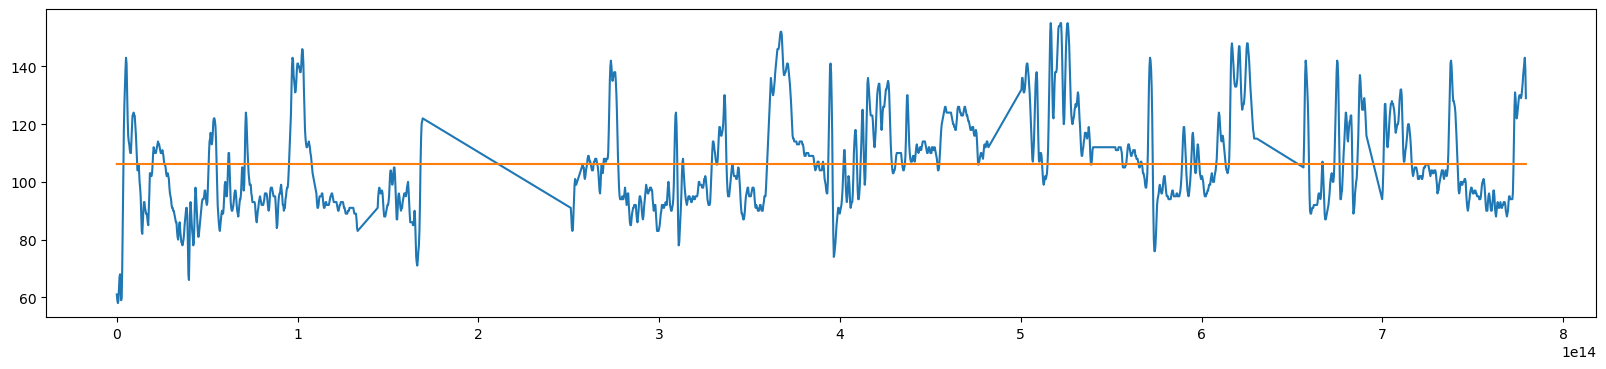

In [19]:
plt.figure(figsize=(20, 4))
plt.plot(test_series.index, test_series['glucose'])
plt.plot(test_series.index, exog.predict(test_series[features]))

In [20]:
features = ['hr', 'eda', 'temp', 'acc', 'calorie', 'total_carb', 'protein', 'sugar', 'gi', 'gl']
target = 'glucose'
exog = LinearRegression()
mses = lr_cv_loop(test_series, exog, features, target)
np.sqrt(mses).mean()

16.820224751120023

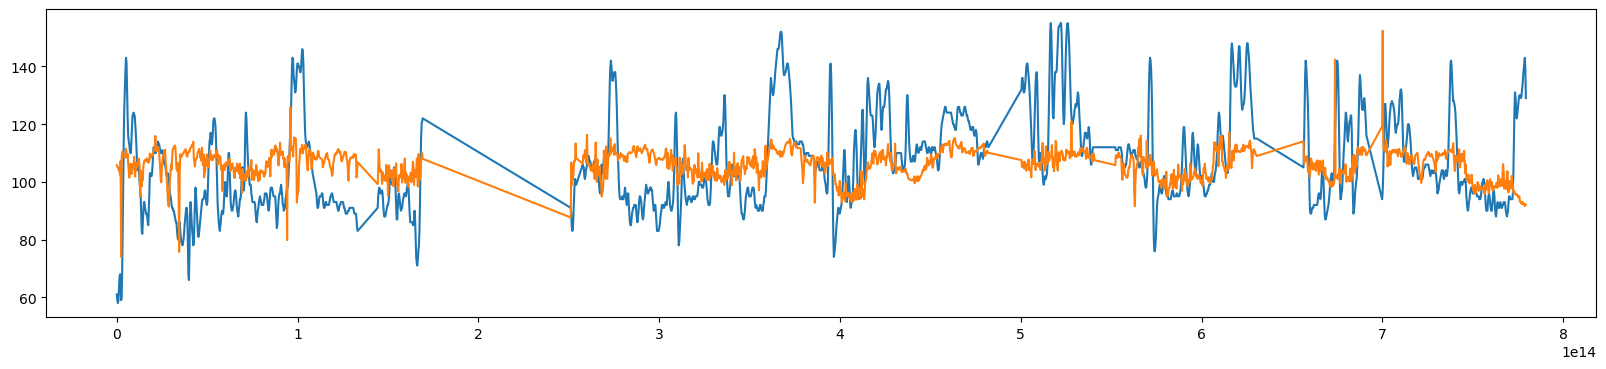

In [21]:
plt.figure(figsize=(20, 4))
plt.plot(test_series.index, test_series['glucose'])
plt.plot(test_series.index, exog.predict(test_series[features]))

In [22]:
features = ['hr', 'eda', 'temp', 'acc']
target = 'glucose'
exog = LinearRegression()
mses = lr_cv_loop(test_series, exog, features, target)
np.sqrt(mses).mean()

16.75904143931296

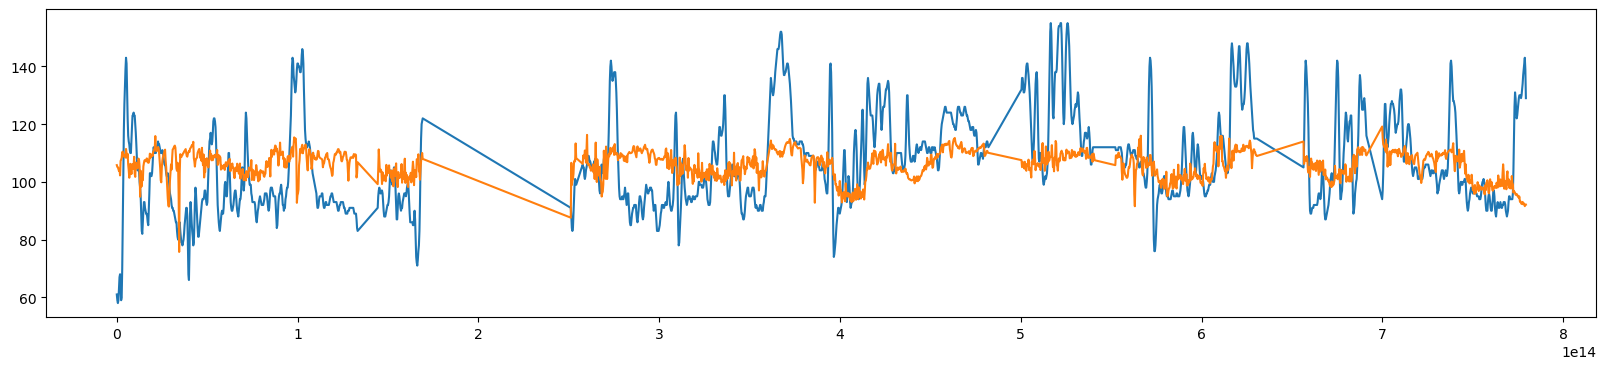

In [23]:
plt.figure(figsize=(20, 4))
plt.plot(test_series['glucose'])
plt.plot(test_series.index, exog.predict(test_series[features]))

## Start time series exploration

In [24]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.tsa as sm
from statsmodels.tsa.api import ARDL

In [25]:
tss = TimeSeriesSplit(n_splits=10)

for train_idx, val_idx in tss.split(test_series):
  g_tt = test_series['glucose'].iloc[train_idx]
  g_ho = test_series['glucose'].iloc[val_idx]


In [26]:
# auto_arima(test['glucose'], seasonal=True, trace=True)

In [27]:
arima = ARIMA(test_series.loc[:pd.Timedelta(days=8), 'glucose'].values, order=(4, 1, 2)).fit()

c:\Users\Noah\miniconda3\envs\erdos_may_2024\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Noah\miniconda3\envs\erdos_may_2024\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Noah\miniconda3\envs\erdos_may_2024\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


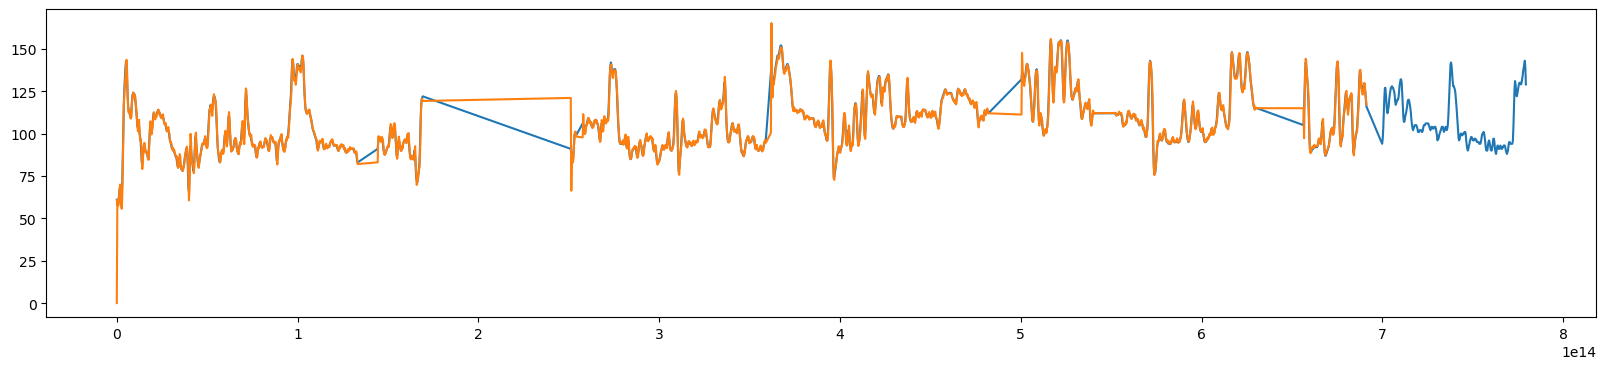

In [28]:
plt.figure(figsize=(20, 4))
plt.plot(test_series['glucose'])
plt.plot(test_series.loc[:pd.Timedelta(days=8), 'glucose'].index, arima.fittedvalues)
# plt.plot(test.index, model.predict(test[features]))

In [29]:
exog = ['hr', 'eda', 'temp', 'acc', 'calorie', 'total_carb', 'protein', 'sugar', 'gi', 'gl']
# exog = ['calorie', 'total_carb', 'dietary_fiber', 'protein']
test_copy = test_series.copy()
test_copy.index = range(len(test_copy))
ardl = ARDL(test_copy.loc[:1500, 'glucose'], 1, test_copy.loc[:1500, exog], 6).fit()

In [30]:
# ardl.summary()

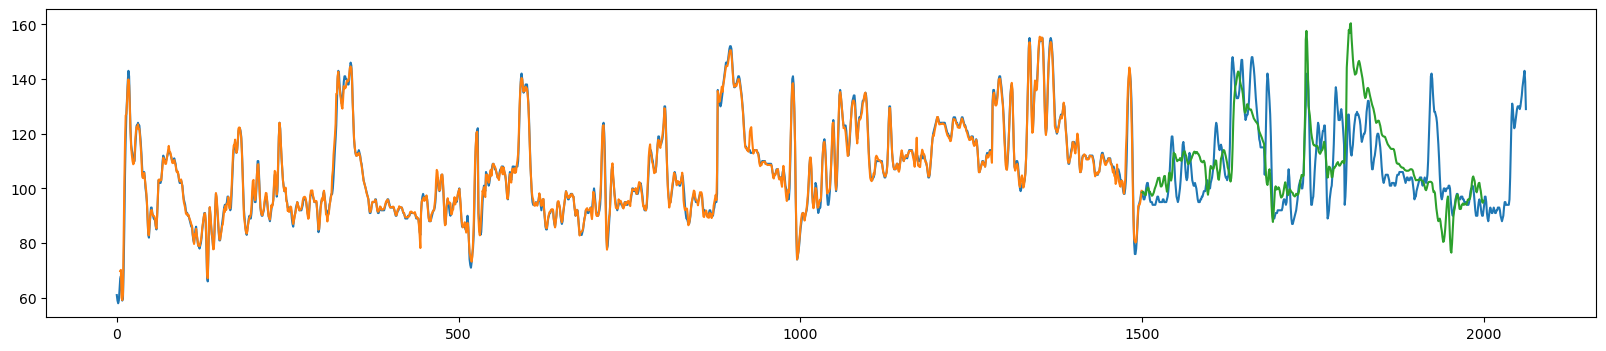

In [31]:
plt.figure(figsize=(20, 4))
plt.plot(test_copy.index, test_copy['glucose'])
plt.plot(test_copy.index[5:1500], ardl.fittedvalues)
plt.plot(test_copy.index[1500:2000], ardl.forecast(500, test_copy.loc[1500:, exog]))

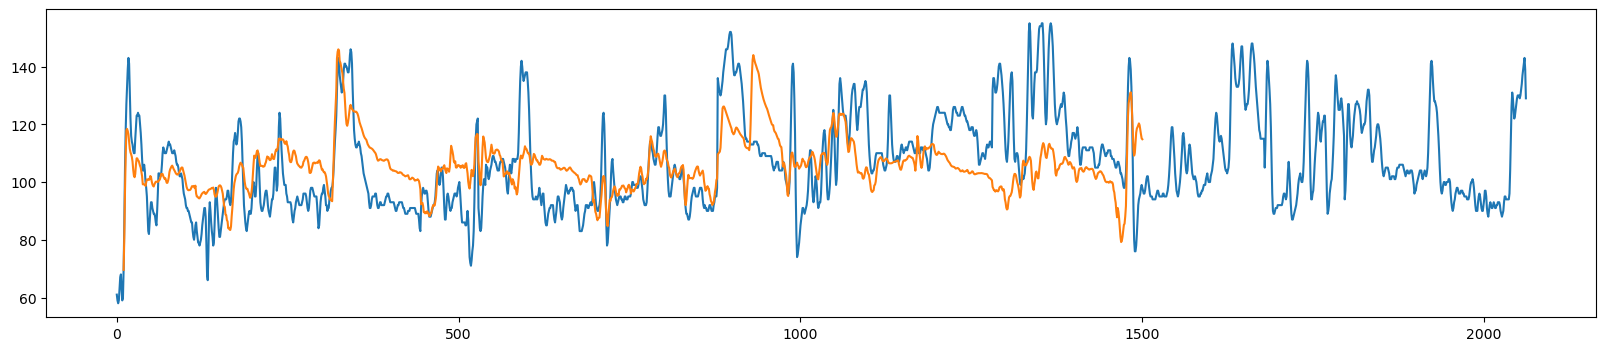

In [32]:
test_pred = ardl.get_prediction(dynamic=True, exog_oos=test_copy.loc[1500:, exog])
plt.figure(figsize=(20, 4))
plt.plot(test_copy.index, test_copy['glucose'])
plt.plot(test_copy.index[10:1501], test_pred.predicted_mean[10:])

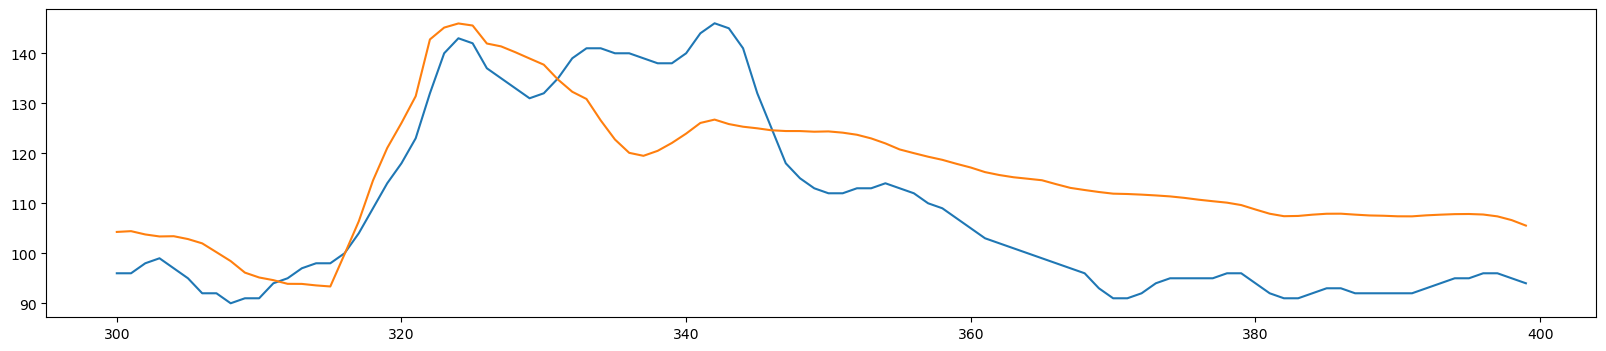

In [33]:
plt.figure(figsize=(20, 4))
plt.plot(test_copy.index[300:400], test_copy['glucose'][300:400])
plt.plot(test_copy.index[300:400], test_pred.predicted_mean[300:400])

In [34]:
exog = ['calorie', 'total_carb', 'dietary_fiber', 'protein']
test_copy = test_series.copy()
test_copy.index = range(len(test_copy))
ardl = ARDL(test_copy.loc[:1500, 'glucose'], 1, test_copy.loc[:1500, exog], 6).fit()

In [35]:
# ardl.summary()

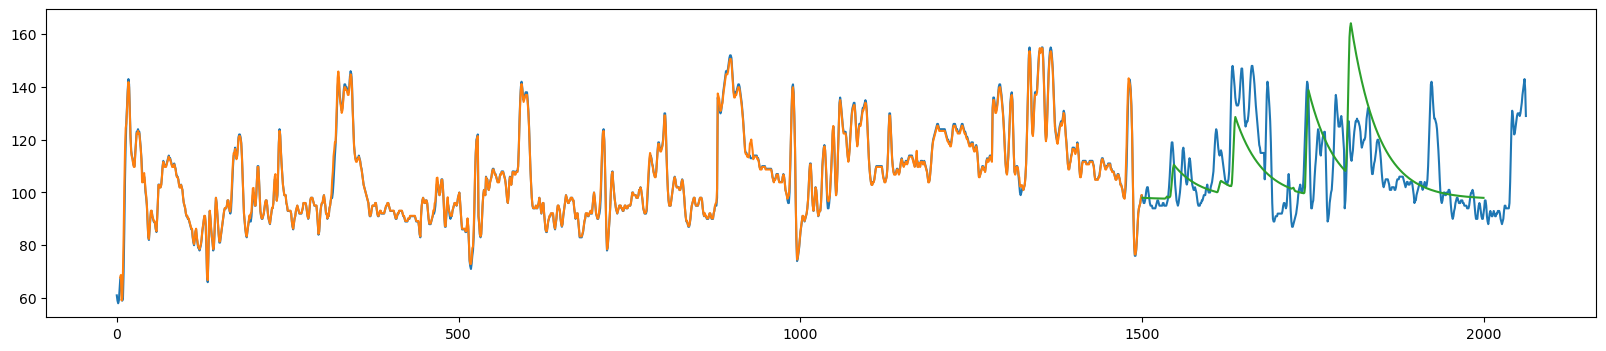

In [36]:
plt.figure(figsize=(20, 4))
plt.plot(test_copy.index, test_copy['glucose'])
plt.plot(test_copy.index[5:1500], ardl.fittedvalues)
plt.plot(test_copy.index[1500:2000], ardl.forecast(500, test_copy.loc[1500:, exog]))

In [37]:
test_pred = ardl.get_prediction(dynamic=True, exog_oos=test_copy.loc[1500:, exog])

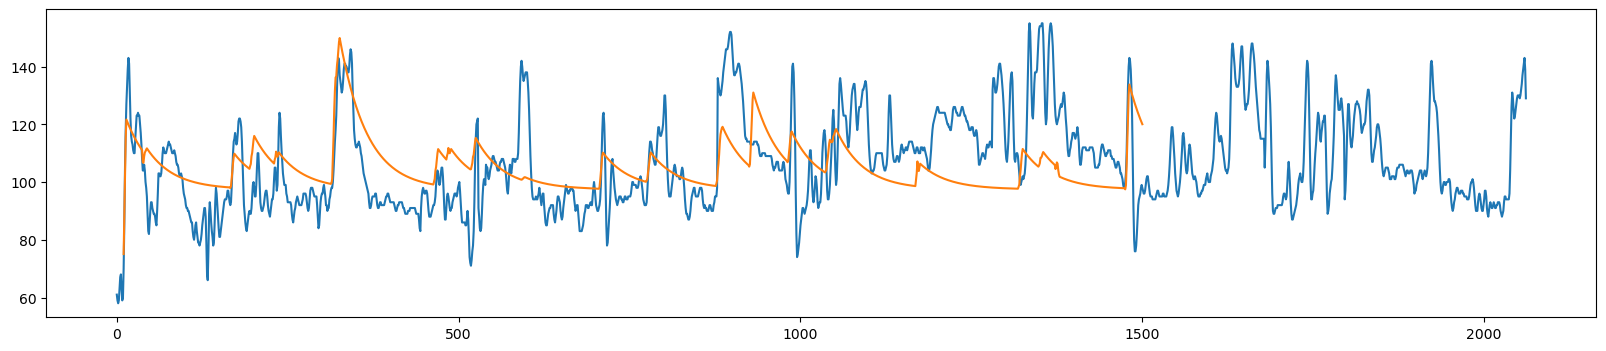

In [38]:
plt.figure(figsize=(20, 4))
plt.plot(test_copy.index, test_copy['glucose'])
plt.plot(test_copy.index[10:1501], test_pred.predicted_mean[10:])

## Run time series over all participants

In [69]:
included_participants = [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 16]
part_series = {}
for participant_num in included_participants:
    test_series = align_series(cgm_data, participant_num)
    # Remove portions with data not recorded from a device
    test_series = test_series[~test_series.isnull().any(axis=1)]
    part_series[participant_num] = test_series

In [73]:
def time_series_cv(train, glu_lag, exog, lags, n_splits):
   target = ['glucose']
   ts_split = TimeSeriesSplit(n_splits)
   mses = np.zeros(n_splits)
   for i, (train_idx, val_idx) in enumerate(ts_split.split(train)):
      train_set = train.iloc[train_idx]
      val_set = train.iloc[val_idx]
      train_set.index = range(len(train_set))
      
      ardl_results = ARDL(train_set[target], glu_lag, train_set[exog], lags).fit()

      pred = ardl_results.forecast(len(val_idx), exog=val_set[exog])
      val_set.index = pred.index

      mses[i] = mean_squared_error(val_set[target], pred)
   return mses

def optimize_participant(train, num_glu_lags, exog, num_exog_lags, n_splits):
   mses = np.zeros((num_glu_lags - 1, num_exog_lags - 1, n_splits))
   for i in range(1, num_glu_lags):
      for j in range(1, num_exog_lags):
         mses[i - 1, j - 1, :] = time_series_cv(train, i, exog, j, n_splits)

   return mses

In [74]:
models = {
   'carb':['total_carb'],
   'gi': ['gi', 'gl'],
   'food': ['calorie', 'total_carb', 'sugar', 'protein'],
   'biometrics': ['hr', 'eda', 'temp', 'acc'],
   'gi_and_bio':['hr', 'eda', 'temp', 'acc', 'gi', 'gl'],
   'food_and_bio': ['hr', 'eda', 'temp', 'acc', 'calorie', 'total_carb', 'sugar', 'protein'],
   'all': ['hr', 'eda', 'temp', 'acc', 'calorie', 'total_carb', 'sugar', 'protein', 'gi', 'gl']
}
num_glu_lags = 6
num_exog_lags = 6
n_splits = 5
test_size = 0.2

# p7 and p13 don't have food aligned, p15 presented fitting issues
train_participants = [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 16]

In [75]:
# Indexes are: participant, model, glu lag, exog lag, n_splits

mses = np.zeros((len(train_participants), len(models), num_glu_lags - 1, num_exog_lags - 1, n_splits))
for i, participant_num in enumerate(train_participants):
    print(participant_num)
    train, test = train_test_split(part_series[participant_num], shuffle=False, test_size=test_size)
    for model_num, exog in enumerate(models.values()):
        mses[i, model_num, :, :, :] = optimize_participant(
            train, num_glu_lags, exog, num_exog_lags, n_splits
        )

1
2
3
4
5
6
8
9
10
11
12
14
16


In [43]:
def get_mean_mses(all_mses):
    # Dimensions are participant, model, glu lag, exog lag
    return np.mean(all_mses, axis=4)

In [44]:
def get_models_with_lowest_mse(mean_mses):
    # Index of model with lowest mse for each participant
    return np.apply_over_axes(np.min, mean_mses, axes=(2, 3)).squeeze().argmin(axis=1) 

In [45]:
mean_mses = get_mean_mses(mses)

In [46]:
# Info on best model for each patient
get_models_with_lowest_mse(mean_mses)

array([5, 1, 0, 4, 4, 0, 4, 1, 1, 4, 1, 0, 0], dtype=int64)

In [47]:
def get_model_params(mean_mses, participant_idx, model_num):
    param_slice = mean_mses[participant_idx, model_num, :, :]
    return np.unravel_index(param_slice.argmin(), param_slice.shape)

In [48]:
get_model_params(mean_mses, 0, 0)

(0, 3)

In [49]:
[get_model_params(mean_mses, i, j) for i,j in zip(range(len(train_participants)), get_models_with_lowest_mse(mean_mses))]

[(0, 2),
 (0, 0),
 (1, 4),
 (1, 0),
 (3, 4),
 (3, 4),
 (0, 3),
 (1, 4),
 (4, 4),
 (2, 3),
 (0, 4),
 (3, 4),
 (3, 4)]

In [50]:
# participant and model
pd.DataFrame(np.apply_over_axes(np.min, mean_mses, axes=(2, 3)).squeeze())

,0,1,2,3,4,5,6
0,244.202175,237.127799,230.511911,241.449720,213.487068,201.355736,204.017209
1,365.370554,364.398070,400.512981,370.132881,373.325294,426.641758,638.237336
2,375.975985,388.285230,629.266061,471.030199,456.009221,510.804573,501.276808
3,382.193038,382.512205,382.183019,351.591731,351.518199,366.376857,352.575832
4,155.237872,149.893364,224.817150,133.928094,112.803041,143.310036,144.047696
5,518.050641,554.896850,569.615407,732.988768,636.241640,679.459980,628.023354
6,278.994022,283.957156,286.269468,329.637565,273.721923,286.334869,284.560437
7,536.359115,523.092885,580.022629,668.122393,627.561933,638.406524,1018.498599
8,574.082100,538.058140,574.549648,646.117263,540.708230,779.298560,641.840917
9,475.502979,485.832262,489.639099,401.526047,399.270558,420.537962,440.350394


In [118]:
# Lowest mses for each participant
np.apply_over_axes(np.min, mean_mses, axes=(1, 2, 3)).squeeze()

array([201.35573639, 364.3980697 , 375.97598484, 351.51819948,
       112.80304094, 518.05064057, 273.72192337, 523.09288519,
       538.05813962, 399.27055759, 266.94756862, 430.41266388,
       282.95637357])

In [113]:
# Participant 1 mses gi model
# 237 for lags 1, 3
pd.DataFrame(mean_mses[0, 1, :, :])

,0,1,2,3,4
0,281.392197,255.666599,237.127799,275.215596,321.718390
1,297.690945,291.284047,303.116959,320.862050,315.397562
2,283.827410,274.074411,282.153765,303.134036,299.359131
3,283.301764,270.800366,275.670345,290.881298,285.187107
4,287.611590,278.265964,282.728836,294.533309,288.918697


In [103]:
# 241 for lags 1, 3
pd.DataFrame(mean_mses[0, 3, :, :])
# np.min(mean_mses[0, 3, :, :])

,0,1,2,3,4
0,247.693784,247.941308,241.449720,244.347355,261.091179
1,296.399383,302.462358,292.657992,291.175323,294.987449
2,285.695609,289.401641,274.153339,276.770649,280.900962
3,274.292573,281.413003,272.378518,272.932996,275.261049
4,277.854968,282.655380,276.574712,274.458282,280.646450


In [101]:
# 213 for lags 1, 3
pd.DataFrame(mean_mses[0, 4, :, :])

,0,1,2,3,4
0,250.893953,228.132320,213.487068,277.853209,359.111010
1,296.519781,302.243334,316.561457,340.100391,336.887062
2,278.921603,280.572312,284.773857,313.895446,325.057372
3,271.466983,272.201104,277.947839,300.557147,305.685360
4,278.294301,279.634022,284.863422,300.353209,304.888777


In [94]:
np.mean(mses[:, 1:], axis=1)

array([[[[  223.53497887,   144.94501098,   369.63462436,
            349.22947716,   160.21051537],
         [  172.44290456,   133.53070721,   343.67276351,
            368.01254369,   147.41005111],
         [  122.48014944,   129.67435227,   310.02570391,
            402.76320412,   141.68112633],
         [  197.24337511,   138.83752187,   293.96105593,
            454.53430107,   148.09994832],
         [  354.52964929,   155.53266912,   287.3216749 ,
            517.55281846,   164.75883393]],

        [[  259.62555119,   137.04470824,   447.27622708,
            437.18814111,   184.74216935],
         [  274.63936349,   144.31399119,   456.23735778,
            448.22417795,   156.14236874],
         [  280.46729512,   148.6097145 ,   436.76150859,
            468.81024566,   152.78462424],
         [  281.16157969,   157.7236349 ,   432.68404363,
            487.16441784,   156.44009178],
         [  297.32516684,   165.25781739,   424.45327812,
            501.63217154,   159

In [53]:
np.unravel_index([np.argmin(np.mean(mses, axis=3)[i, :, :]) for i in range(5)], (6, 6))

ValueError: index 60 is out of bounds for array with size 36

In [ ]:
np.unravel_index([np.argmin(np.mean(mses, axis=3)[i, :, :]) for i in range(6)], (6, 6))

(array([1, 1, 1, 1, 1, 1], dtype=int64),
 array([3, 3, 3, 4, 3, 3], dtype=int64))

In [ ]:
np.unravel_index([np.argmin(np.mean(mses, axis=3)[i, :, :]) for i in range(6)], (6, 6))

(array([4, 4, 3, 4, 4, 1], dtype=int64),
 array([1, 0, 0, 2, 2, 0], dtype=int64))

In [ ]:
np.unravel_index([np.argmin(np.mean(mses, axis=3)[i, :, :]) for i in range(6)], (6, 6))

(array([5, 5, 5, 5, 5, 2], dtype=int64),
 array([0, 0, 0, 4, 4, 0], dtype=int64))

In [ ]:
np.unravel_index([np.argmin(np.mean(mses, axis=3)[i, :, :]) for i in range(6)], (6, 6))

(array([4, 4, 4, 0, 2, 3], dtype=int64),
 array([5, 1, 5, 0, 0, 0], dtype=int64))

In [ ]:
np.unravel_index([np.argmin(np.mean(mses, axis=3)[i, :, :]) for i in range(6)], (6, 6))

(array([1, 1, 5, 4, 4, 5], dtype=int64),
 array([3, 3, 2, 4, 3, 2], dtype=int64))

In [ ]:
print(np.mean(mses, axis=3)[0, 1, 3])
print(np.mean(mses, axis=3)[1, 4, 3])
print(np.mean(mses, axis=3)[2, 1, 4])
print(np.mean(mses, axis=3)[3, 1, 3])
print(np.mean(mses, axis=3)[4, 1, 3])

237.12898948276256
248.77323526091135
246.9470346670896
208.91532668824726
215.60918437262248


In [54]:
np.array([np.argmin(np.mean(mses, axis=3)[i, :, :]) for i in range(5)])

array([ 60,  98,  44, 174, 127], dtype=int64)

In [55]:
np.apply_over_axes(np.argmin, np.mean(mses, axis=3), axes=(1, 2))

array([[[[1, 0, 1, 0, 0]]],


       [[[0, 0, 0, 0, 1]]],


       [[[1, 0, 0, 1, 1]]],


       [[[0, 1, 0, 0, 0]]],


       [[[0, 0, 0, 0, 0]]],


       [[[0, 0, 1, 1, 1]]],


       [[[0, 0, 1, 0, 0]]],


       [[[0, 0, 3, 0, 1]]],


       [[[1, 0, 0, 0, 0]]],


       [[[0, 0, 0, 0, 0]]],


       [[[0, 0, 0, 0, 0]]],


       [[[0, 0, 0, 0, 1]]],


       [[[0, 0, 3, 0, 2]]]], dtype=int64)

In [56]:
np.mean(time_series_cv(models['carb'], 3, 1))

TypeError: time_series_cv() missing 2 required positional arguments: 'lags' and 'n_splits'

In [57]:
np.mean(mses, axis=3)

array([[[[1.46691696e+02, 1.41924200e+02, 3.62011230e+02,
          4.78586033e+02, 1.66214602e+02],
         [1.87475614e+02, 1.54945213e+02, 4.28963084e+02,
          5.01913465e+02, 1.54280610e+02],
         [1.22300946e+02, 1.52878022e+02, 4.15084724e+02,
          4.98063564e+02, 1.50454302e+02],
         [1.31724255e+02, 1.48689109e+02, 3.95618072e+02,
          4.89860985e+02, 1.46026000e+02],
         [1.58043214e+02, 1.50236524e+02, 4.01906190e+02,
          4.90597459e+02, 1.45952790e+02]],

        [[2.78268820e+02, 1.34732441e+02, 3.19809671e+02,
          4.70011874e+02, 1.68297774e+02],
         [2.80052927e+02, 1.49841665e+02, 4.21699910e+02,
          4.95039988e+02, 1.81717070e+02],
         [2.19672556e+02, 1.47769974e+02, 4.04920660e+02,
          4.91249443e+02, 1.78936121e+02],
         [2.16751346e+02, 1.45098919e+02, 3.84483002e+02,
          4.83234662e+02, 1.76272951e+02],
         [2.33235718e+02, 1.46373599e+02, 3.91333879e+02,
          4.84585382e+02, 1.765

In [ ]:
# Loop over each participant
# get the best model from ech participant
# Use get_prediction to plot the prediction on the holdout interval (optionally internal prediction if the resutls don't look good)

# plot needs a train trace, test trace, and a prediction trace

25

In [ ]:
# for best model in zip(i,j)

In [89]:
def validation_pred(series, glu_lag, exog, exog_lag):
    train, test = train_test_split(series, shuffle=False, test_size=0.2)
    train_idx = train.index
    test_idx = test.index
    train.index = range(len(train))
    test.index = range(len(test))
    ardl = ARDL(train['glucose'], glu_lag, train[exog], exog_lag).fit()
    
    pred = ardl.get_prediction(start=len(train), end=len(train)+len(test) - 1, exog_oos=test[exog])
    train.index = train_idx 
    test.index = test_idx 

    return train, test, pred


def plot_series_validation(train, test, ardl_pred):
    plt.figure(figsize=(10, 4))

    start_idx = len(train) - len(test)

    plt.plot(train.index[start_idx:], train.loc[train.index[start_idx: ], 'glucose'], color='tab:blue', label='train')
    plt.plot(test.index, test['glucose'], color='tab:green', label='test (actual)')
    plt.plot(test.index, ardl_pred.predicted_mean, color='tab:orange', alpha=0.7, label='test (prediction)')
    plt.legend()
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Blood Glucose Conc. (mg/dl)', fontsize=14)
    # plt.plot(test.index, ardl_pred.predicted_mean - 1.28 * ardl_pred.se_mean, color='tab:orange', linestyle='--')
    # plt.plot(test.index, ardl_pred.predicted_mean + 1.28 * ardl_pred.se_mean, color='tab:orange', linestyle='--')


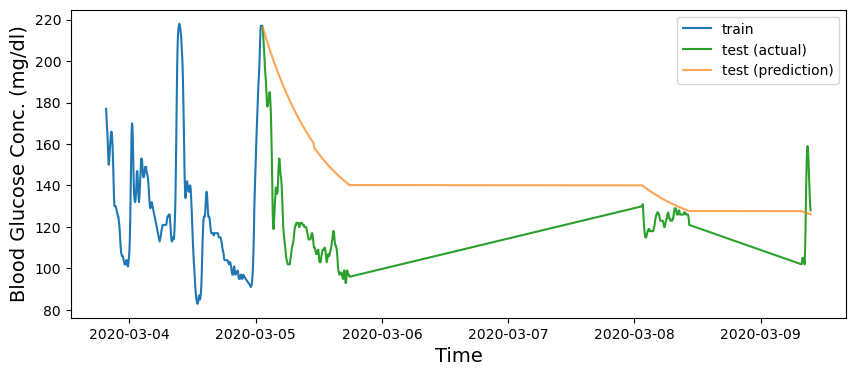

In [119]:
for i in train_participants[0:1]:
    a, b, c = validation_pred(part_series[i], 1, models['gi'], 3)
    plot_series_validation(a, b, c)

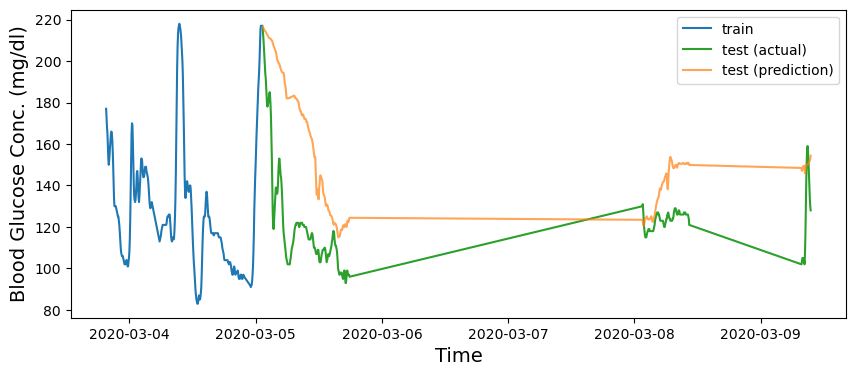

In [120]:
for i in train_participants[0:1]:
    a, b, c = validation_pred(part_series[i], 1, models['biometrics'], 3)
    plot_series_validation(a, b, c)

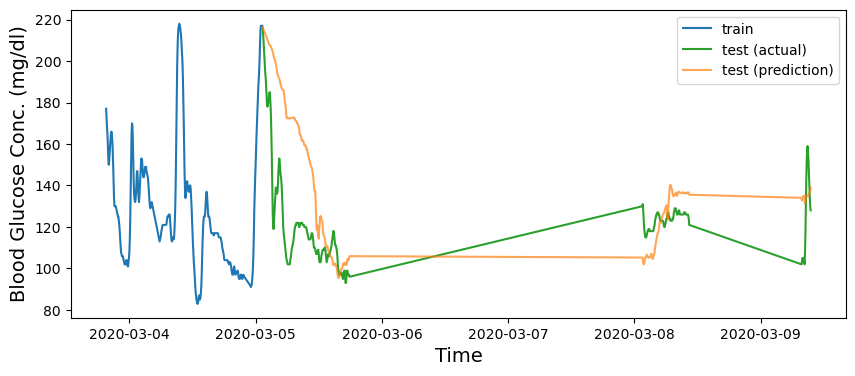

In [121]:
for i in train_participants[0:1]:
    a, b, c = validation_pred(part_series[i], 1, models['gi_and_bio'], 3)
    plot_series_validation(a, b, c)

In [136]:
def wow_pred(series, glu_lag, exog, exog_lag):
    train, test = train_test_split(series, shuffle=False, test_size=0.6)
    train_idx = train.index
    test_idx = test.index
    train.index = range(len(train))
    test.index = range(len(test))
    ardl = ARDL(train['glucose'], glu_lag, train[exog], exog_lag).fit()
    
    pred = ardl.get_prediction(start=len(train), end=len(train)+len(test) - 1, exog_oos=test[exog])
    train.index = train_idx 
    test.index = test_idx 

    return train, test, pred


def plot_series_wow(train, test, ardl_pred):
    plt.figure(figsize=(10, 4))

    start_idx = round(len(train) / 2)

    plt.plot(train.index[start_idx:], train.loc[train.index[start_idx: ], 'glucose'], color='tab:blue', label='train')
    plt.plot(test.index, test['glucose'], color='tab:green', label='test (actual)')
    plt.plot(test.index, ardl_pred.predicted_mean, color='tab:orange', alpha=0.7, label='test (prediction)')
    plt.legend()
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Blood Glucose Conc. (mg/dl)', fontsize=14)
    # plt.plot(test.index, ardl_pred.predicted_mean - 1.28 * ardl_pred.se_mean, color='tab:orange', linestyle='--')
    # plt.plot(test.index, ardl_pred.predicted_mean + 1.28 * ardl_pred.se_mean, color='tab:orange', linestyle='--')


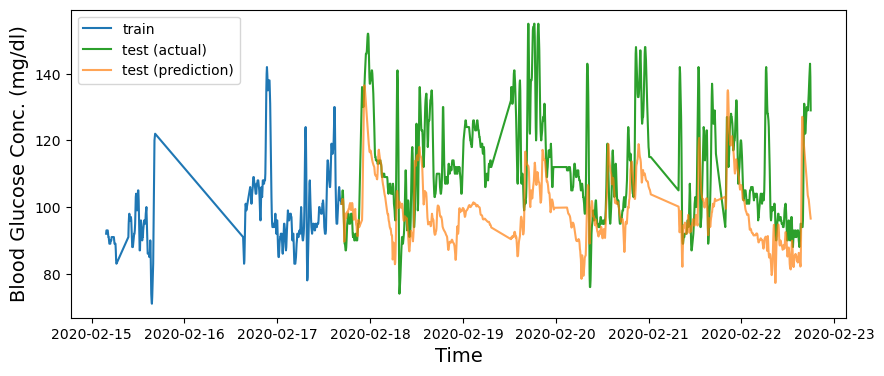

In [137]:
for i in train_participants[0:1]:
    a, b, c = wow_pred(part_series[i], 1, models['gi_and_bio'], 6)
    plot_series_wow(a, b, c)

In [62]:
start_idx = len(a) - len(b)

In [ ]:
# Patient 1 plots
